## Import Packages

In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

## Get a Convenient Dataset to Play With
This is for demonstration purposes only. Skip this section when implementing these functions in your notebook with your dataframe.

_Fetch the demonstration dataset and stick it in a pandas dataframe. There are 20,648 observations in this Sklearn dataset of California housing prices. The 8 feature columns reside in the dataset.data structure._

In [2]:
from sklearn.datasets import fetch_california_housing

In [3]:
dataset = fetch_california_housing()

In [4]:
df = pd.DataFrame(dataset.data,
                  columns=[dataset.feature_names]
                  )
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [5]:
df.shape

(20640, 8)

_Create the target column “price” (prices, in $ 000,000) which resides in the dataset.target structure. It happens to be placed into a multilevel column index, so I will need to flatten that to one level, as below. I also verified that there were no null values, just to be sure._

In [6]:
df['price'] = 100_000 * dataset.target
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,452600.0
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,358500.0
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,352100.0
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,341300.0
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,342200.0


In [7]:
df.isna().sum().sum()

0

In [8]:
df.columns

MultiIndex([(    'MedInc',),
            (  'HouseAge',),
            (  'AveRooms',),
            ( 'AveBedrms',),
            ('Population',),
            (  'AveOccup',),
            (  'Latitude',),
            ( 'Longitude',),
            (     'price',)],
           )

In [9]:
df.columns = df.columns.get_level_values(0)

In [10]:
df.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'price'],
      dtype='object')

## Function: Half-masked Correlation Heatmap

_There aren’t any non-numerical columns in this dataset, but most often, there will be plenty of data cleaning, binarizing, checking datatypes, etc. to do._

_Start with a quick look at the Pearson correlation coefficients. Visualizing on a heatmap is a nice way to go for this,and mask half of it with a white upper triangle._

In [11]:
# Required parameter: dataframe ... the reference pandas dataframe
# Optional parameters: title ... (string) chart title
#                      file  ... (string) path+filename if you want to save image


def half_masked_corr_heatmap(dataframe, title=None, file=None):
    plt.figure(figsize=(9,9))
    sns.set(font_scale=1)

    mask = np.zeros_like(dataframe.corr())
    mask[np.triu_indices_from(mask)] = True

    with sns.axes_style("white"):
        sns.heatmap(dataframe.corr(), mask=mask, annot=True, cmap='coolwarm')

    if title: plt.title(f'\n{title}\n', fontsize=18)
    plt.xlabel('')    # optional in case you want an x-axis label
    plt.ylabel('')    # optional in case you want a  y-axis label
    if file: plt.savefig(file, bbox_inches='tight')
    plt.show();
    
    return

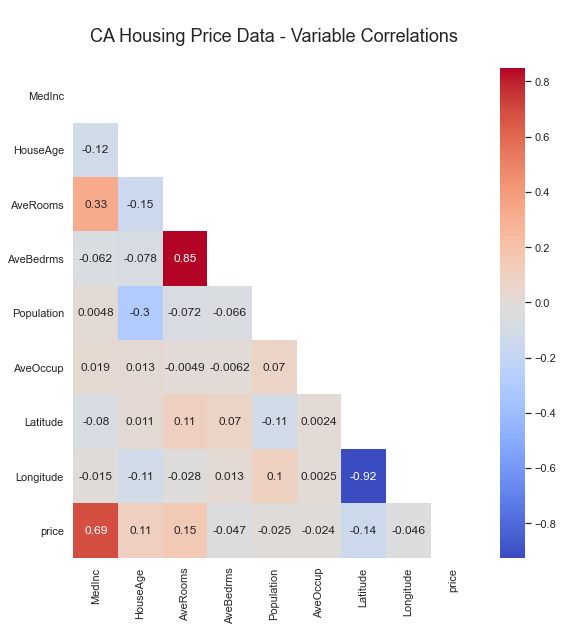

In [12]:
half_masked_corr_heatmap(df,
                         'CA Housing Price Data - Variable Correlations',
                         'Plots/Corr to Target.jpg')

## Function: Corr to a Target Variable (heat-spectrum)

In [13]:
# Required parameters: dataframe ... the reference pandas dataframe
#                      target ... (string) column name of the target variable

# Optional parameters: title ... (string) chart title
#                      file  ... (string) path+filename if you want to save image

def corr_to_target(dataframe, target, title=None, file=None):
    plt.figure(figsize=(4,6))
    sns.set(font_scale=1)
    
    sns.heatmap(dataframe.corr()[[target]].sort_values(target,
                                                ascending=False)[1:],
                annot=True,
                cmap='coolwarm')
    
    if title: plt.title(f'\n{title}\n', fontsize=18)
    plt.xlabel('')    # optional in case you want an x-axis label
    plt.ylabel('')    # optional in case you want a  y-axis label
    if file: plt.savefig(file, bbox_inches='tight')
    plt.show();
    
    return

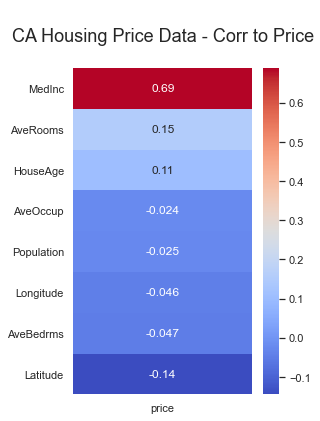

In [14]:
corr_to_target(df, 'price',
               'CA Housing Price Data - Corr to Price',
               'Plots/Corr to Price.jpg'
              )

## Function: Scatterplots of All Features vs. Target

_Survey of scatterplots of each potential feature variable vs. the target is a typical next step. The function rotates continuously through this list of colors for each subplot in the feature list._

In [15]:
# Suptitle formatting adapted from Stackoverflow, Alexander McFarlane
# https://stackoverflow.com/questions/7066121/
#   how-to-set-a-single-main-title-above-all-the-subplots-with-pyplot/35676071

# N-across scatterplots of each feature vs. target ...
# Required parameters: dataframe ... the reference pandas dataframe
#                      target ... (string) column name of the target variable

# Optional parameters: title ... (string) chart title
#                      file  ... (string) path+filename if you want to save image


def gen_scatterplots(dataframe, target_column, list_of_columns, cols=1, file=None):
    rows      = math.ceil(len(list_of_columns)/cols)
    figwidth  = 5 * cols
    figheight = 4 * rows

    fig, ax = plt.subplots(nrows   = rows,
                           ncols   = cols,
                           figsize = (figwidth, figheight))
    
    color_choices = ['blue', 'grey', 'goldenrod', 'r', 'black', 'darkorange', 'g']

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    ax = ax.ravel()         # Ravel turns a matrix into a vector... easier to iterate

    for i, column in enumerate(list_of_columns):
        ax[i].scatter(dataframe[column],
                      dataframe[target_column],
                      color=color_choices[i % len(color_choices)],
                      alpha = 0.1)

#           Individual subplot titles, optional
#             ax[i].set_title(f'{column} vs. {target_column}', fontsize=18)

        ax[i].set_ylabel(f'{target_column}', fontsize=14)
        ax[i].set_xlabel(f'{column}', fontsize=14)

    fig.suptitle('\nEach Feature vs. Target Scatter Plots', size=24)
    fig.tight_layout()
    fig.subplots_adjust(bottom=0, top=0.88)
    if file: plt.savefig(file, bbox_inches='tight')
    plt.show();
    return

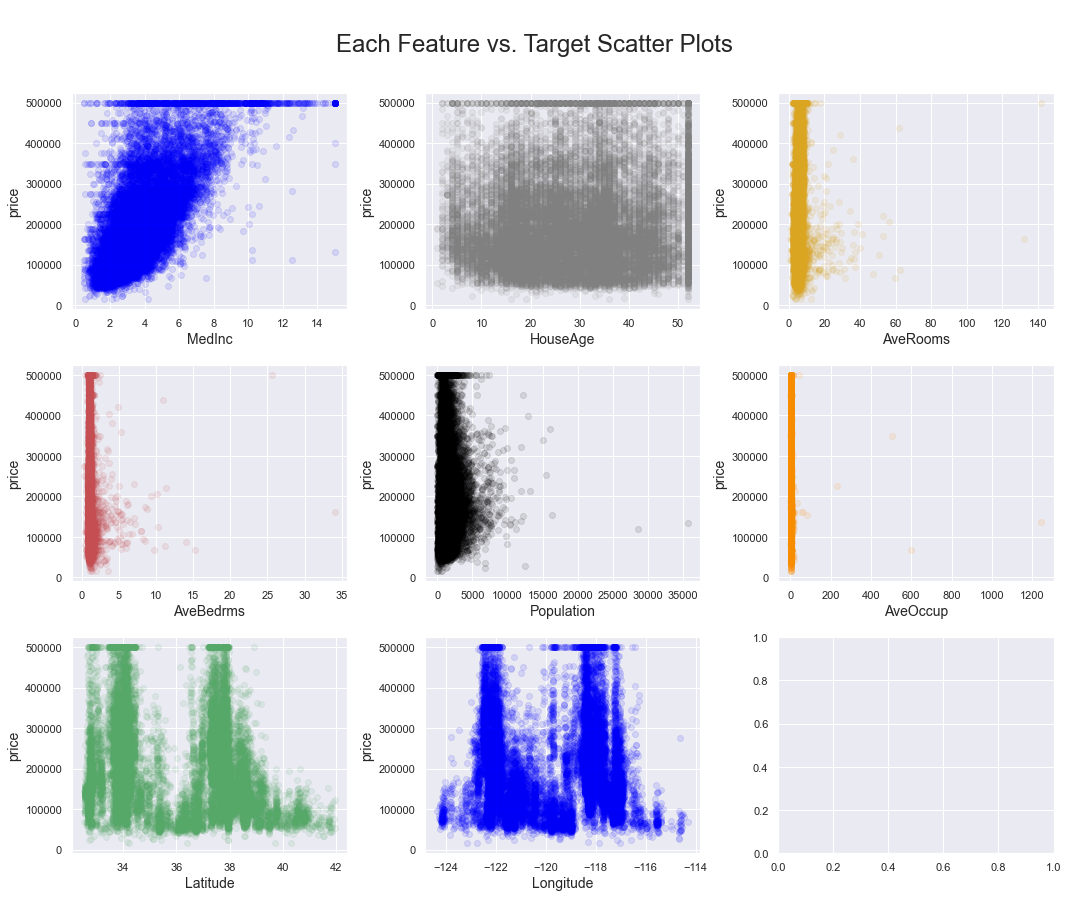

In [16]:
feature_cols = [col for col in df.columns if col != 'price']
gen_scatterplots(df, 'price',
                 feature_cols,
                 3,
                 'Plots/Feature Target Scatter Plots.jpg'
                )

## Function: N-across Histograms of Each Variable

_What do the variable observations look like? Do things look normally distributed? Only a statsmodel normal test will give you a definitive answer, but visual inspection is always a good idea._

In [17]:
# N-across Histograms of each variable in the dataframe ...
# Required parameter: dataframe ... the reference pandas dataframe

# Optional parameters: cols ... no. of subplot columns across fig; default=1
#                      file  ... (string) path+filename if you want to save image

def gen_histograms(dataframe, cols=1, file=None):
    rows      = math.ceil(len(dataframe.columns)/cols)
    figwidth  = 5 * cols
    figheight = 4 * rows

    fig, ax = plt.subplots(nrows   = rows,
                           ncols   = cols,
                           figsize = (figwidth, figheight))
    
    color_choices = ['blue', 'grey', 'goldenrod', 'r', 'black', 'darkorange', 'g']
    ax = ax.ravel()         # Ravel turns a matrix into a vector... easier to iterate

    for i, column in enumerate(dataframe.columns):
        ax[i].hist(dataframe[column],
                      color=color_choices[i % len(color_choices)],
                      alpha = 1)
        
        ax[i].set_title(f'{dataframe[column].name}', fontsize=18)
        ax[i].set_ylabel('Observations', fontsize=14)
        ax[i].set_xlabel('', fontsize=14)
        
    fig.suptitle('\nHistograms for All Variables in Dataframe', size=24)
    fig.tight_layout()
    fig.subplots_adjust(bottom=0, top=0.88)
    if file: plt.savefig(file, bbox_inches='tight')
    plt.show();

    return

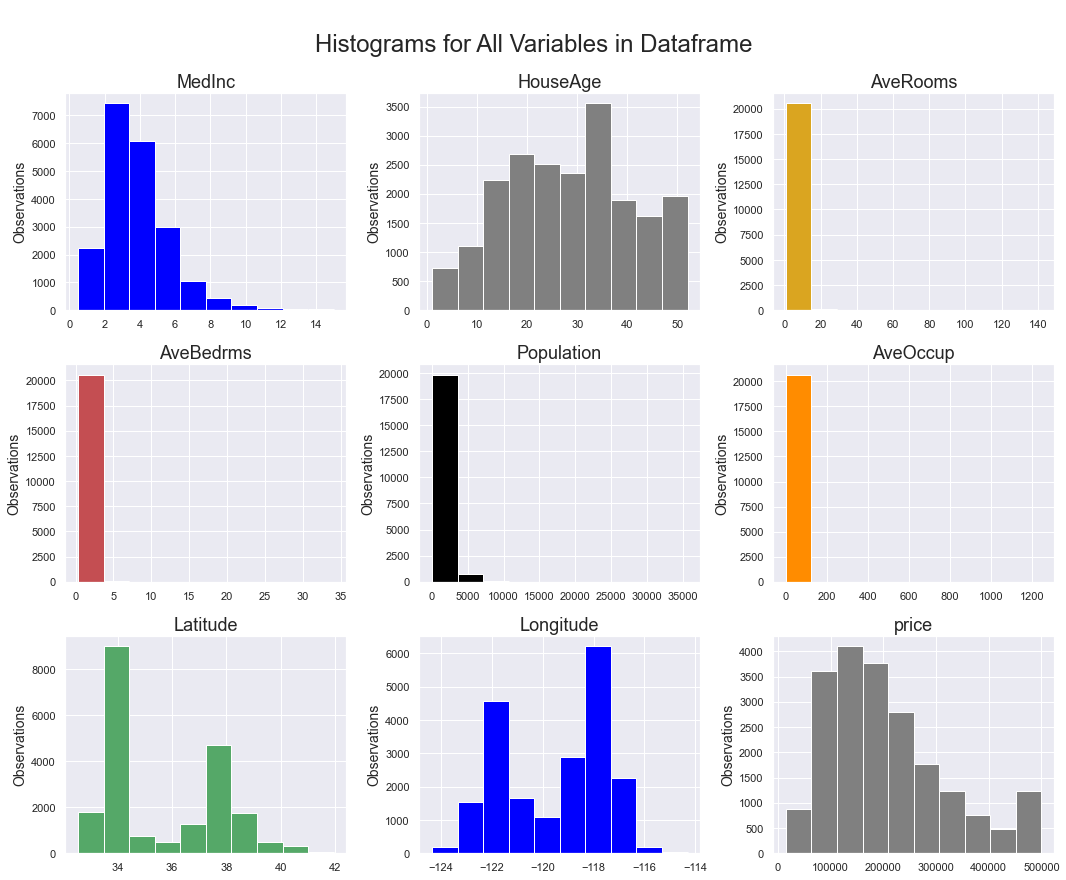

In [18]:
gen_histograms(df, 3,
               'Plots/All var Histograms.jpg'
              )


## Function: Boxplots

In [19]:
# N-across boxplots of each variable in the dataframe ...
# Required parameter: dataframe ... the reference pandas dataframe

# Optional parameters: cols ... no. of subplot columns across fig; default=1
#                      file  ... (string) path+filename if you want to save image


def gen_boxplots(dataframe, cols=1, file=None):
    rows      = math.ceil(len(dataframe.columns)/cols)
    figwidth  = 5 * cols
    figheight = 4 * rows

    fig, ax = plt.subplots(nrows   = rows,
                           ncols   = cols,
                           figsize = (figwidth, figheight))
    
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    ax = ax.ravel()         # Ravel turns a matrix into a vector... easier to iterate

    for i, column in enumerate(dataframe.columns):
        ax[i].boxplot(dataframe[column])
        
        ax[i].set_title(f'{dataframe[column].name}', fontsize=18)
        ax[i].set_ylabel('', fontsize=14)
        ax[i].set_xlabel('', fontsize=14)
        ax[i].tick_params(labelbottom=False)
        
    fig.suptitle('\nBoxplots for All Variables in Dataframe', size=24)
    fig.tight_layout()
    fig.subplots_adjust(bottom=0, top=0.88)
    if file: plt.savefig(file, bbox_inches='tight')
    plt.show();

    return

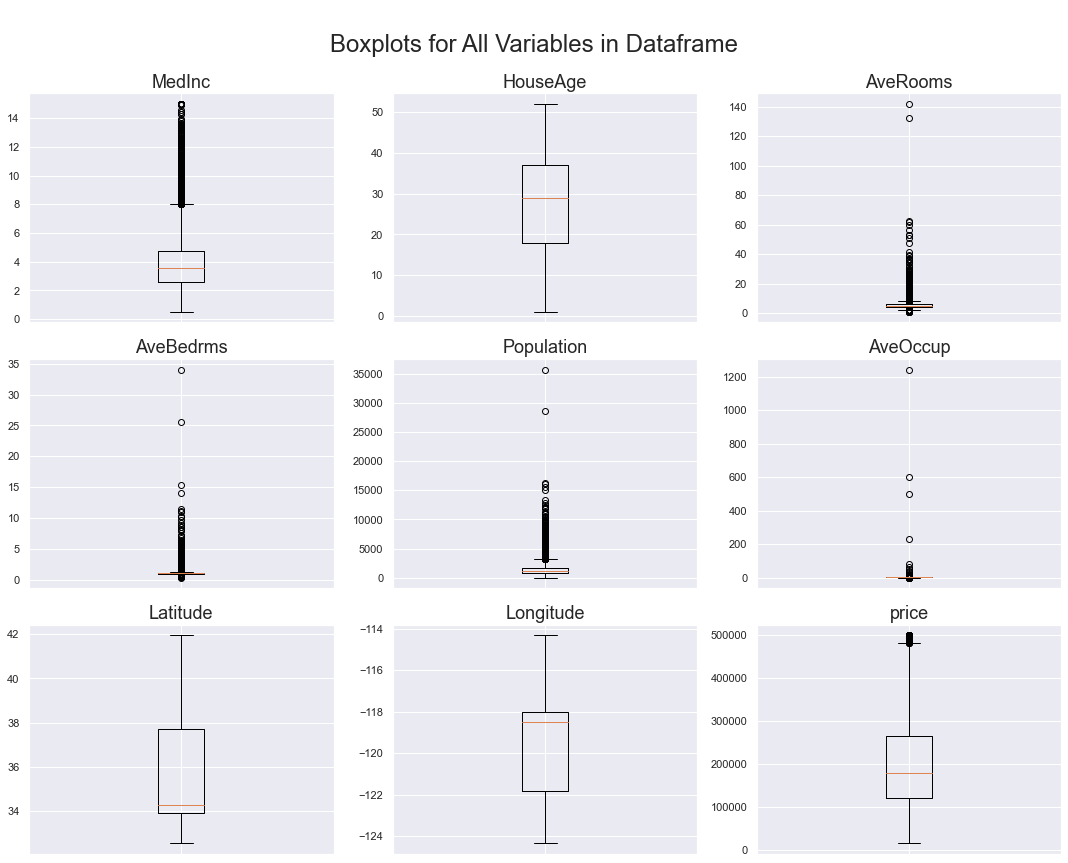

In [20]:
gen_boxplots(df, 3,
             'Plots/All Var Boxplots.jpg'
            )

## Function: N-across Line Charts

_Line chart functions to create current CA Housing Prices dataset._

In [21]:
# N-across Line Charts of each variable in the dataframe ...
# Required parameter: dataframe ... the reference pandas dataframe

# Optional parameters: cols ... no. of subplot columns across fig; default=1
#                      file  ... (string) path+filename if you want to save image


def gen_linecharts(dataframe, cols=1, file=None):
    list_of_columns = list(dataframe.columns)
    rows      = math.ceil(len(list_of_columns)/cols)
    figwidth  = 5 * cols
    figheight = 4 * rows

    fig, ax = plt.subplots(nrows   = rows,
                           ncols   = cols,
                           figsize = (figwidth, figheight))
    
    color_choices = ['blue', 'grey', 'goldenrod', 'r', 'black', 'darkorange', 'g']

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    ax = ax.ravel()         # Ravel turns a matrix into a vector... easier to iterate

    for i, column in enumerate(list_of_columns):
        ax[i].plot(dataframe[column],
                   color=color_choices[i % len(color_choices)])
        
        ax[i].set_title(f'{column}', fontsize=18)
        ax[i].set_ylabel(f'{column}', fontsize=14)
        
    fig.suptitle('\nLine Graphs for All Variables in Dataframe', size=24)
    fig.tight_layout()
    fig.subplots_adjust(bottom=0, top=0.88)
    if file: plt.savefig(file, bbox_inches='tight')
    plt.show();
    
    return

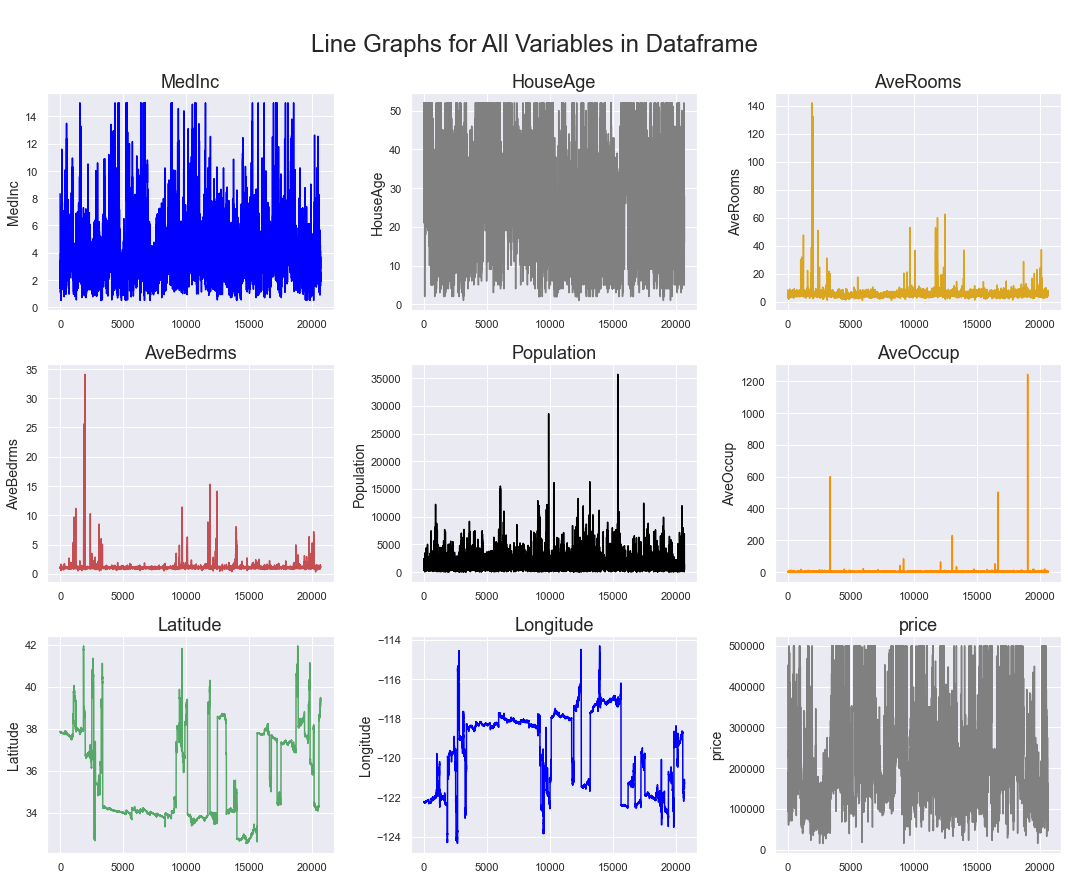

In [22]:
gen_linecharts(df, 3,
               'Plots/All Var Linecharts.jpg'
              )

## Function: N-across Line Charts with User-specified Rolling Average

In [23]:
# N-across Rolling Avg Line Charts of each variable in the dataframe ...
# Required parameters: dataframe ... the reference pandas dataframe
#                      roll_num ... periods over which to calc rolling avg

# Optional parameters: cols ... no. of subplot columns across fig; default=1
#                      file  ... (string) path+filename if you want to save image

def gen_linecharts_rolling(dataframe, roll_num, cols=1, file=None):
    list_of_columns = list(dataframe.columns)    
    rows      = math.ceil(len(list_of_columns)/cols)
    figwidth  = 5 * cols
    figheight = 4 * rows
    
    dataframe = dataframe.rolling(roll_num).mean()

    fig, ax = plt.subplots(nrows   = rows,
                           ncols   = cols,
                           figsize = (figwidth, figheight))
    
    color_choices = ['blue', 'grey', 'goldenrod', 'r', 'black', 'darkorange', 'g']

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    ax = ax.ravel()         # Ravel turns a matrix into a vector... easier to iterate

    for i, column in enumerate(list_of_columns):
        ax[i].plot(dataframe[column],
                   color=color_choices[i % len(color_choices)])
        
        ax[i].set_title(f'{column}', fontsize=18)
        ax[i].set_ylabel(f'{column}', fontsize=14)
        ax[i].set_xlabel('Time', fontsize=14)
        
    fig.suptitle('\nRolling Avg. Line Graphs (all vars)', size=24)
    fig.tight_layout()
    fig.subplots_adjust(bottom=0, top=0.88)
    if file: plt.savefig(file, bbox_inches='tight')
    plt.show();
    
    return

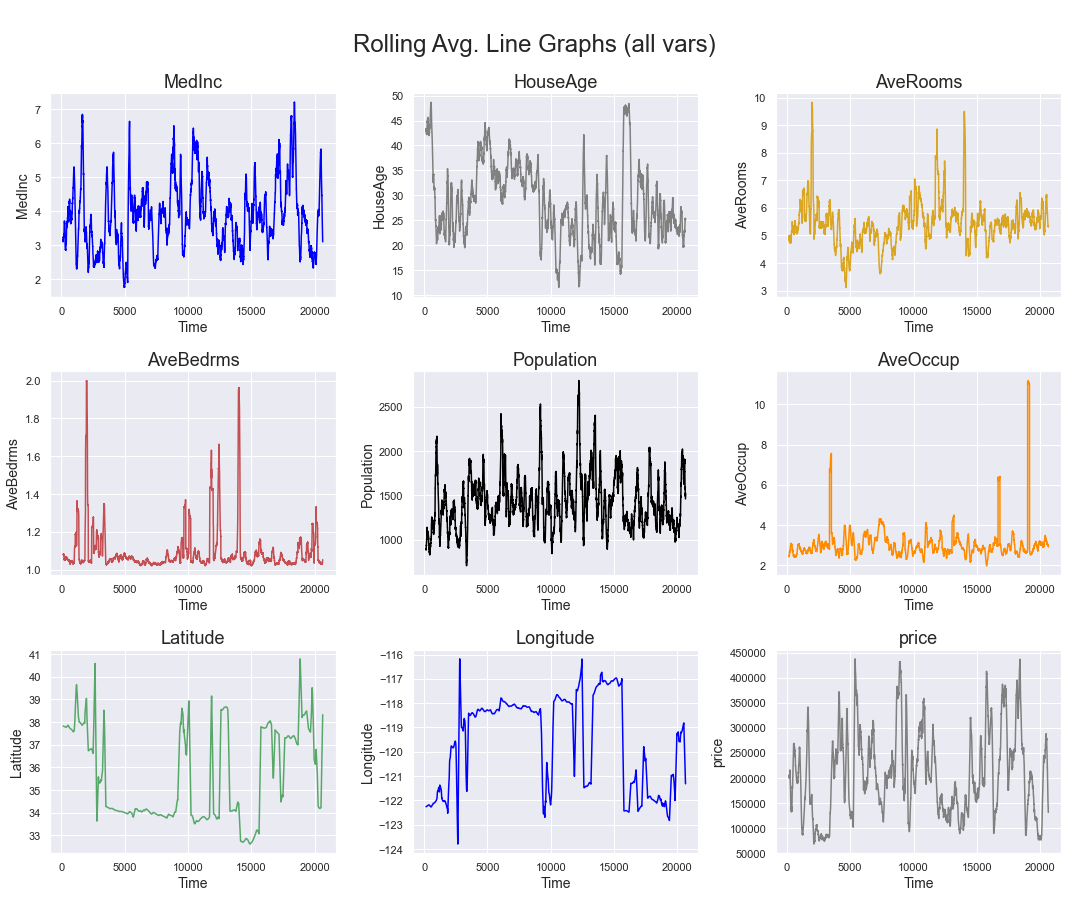

In [24]:
gen_linecharts_rolling(df, 150, 3,
                      'Plots/All Var Rolling Line Charts.jpg'
                      )